ChEn-3170: Computational Methods in Chemical Engineering Spring 2020 UMass Lowell; Prof. V. F. de Almeida **14Apr20**

# 15. Multiple Reactions at Equilibrium
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Jmtrx}{\boldsymbol{\mathsf{J}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\Xmtrx}{\boldsymbol{\mathsf{X}}}
  \newcommand{\Kmtrx}{\boldsymbol{\mathsf{K}}}
  \newcommand{\xvec}{\boldsymbol{x}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\abs}[1]{\left\lvert{#1}\right\rvert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \DeclareMathOperator{\gradx}{\nabla\!_{\xvec}}
  \newcommand{\Kcal}{\mathcal{K}}
  \newcommand{\Kcalvec}{\boldsymbol{\mathcal{K}}}
  \newcommand{\epsvec}{\boldsymbol{\varepsilon}}
$

---
## Table of Contents
* [Introduction](#intro)
* [Algorithm](#algo)
* [Input Data](#idata)
* [Analyze Reaction Mechanism](#analyze)
* [Setup Problem 1](#set1)
  - [Plot Equilibrium Vector Function 1](#eqfunc1)
  - [Solve for Equilibrium 1](#solve1)
  - [Plot Equilibrium Point 1](#eqpt1)
* [Setup Problem 2](#set2)
  - [Solve for Equilibrium 2](#solve2)
---

## Introduction<a id="intro"></a>
In the previous [notebook](https://nbviewer.jupyter.org/github/dpploy/chen-3170/blob/master/notebooks/14-single-reaction-equilibrium.ipynb), a general method for finding equilibrium molar fractions for a single chemical reaction in equilibrium was developed (any number of chemical species and any stoichiometry). Here we further extend the method for a reaction mechanism involving multiple reactions.
Newton's method for computing roots of multiple non-linear equations, $\Kcal\bigl(\xvec(\widehat{\epsvec})\bigr)=0$, is described in the course notes OneNote [ChEn-3170-nonlinalg-c](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/Ei3KyNR90cVBnzOTgU04-1YBlN77e7yejChMxKWtZD3jtg?e=E7O0ve).

In the case of multiple reactions we write the equilibrium functions (vector-valued function) as a vector with components

\begin{equation*}
\Kcal_i\bigl(\xvec\bigr)= K_{x,i} - \prod\limits_{j=1}^N\, x_j^{S_{i,j}} = 0,
\end{equation*}

where $i$ is the index of each reaction.

In [1]:
'''Equilibrium function vector'''

def keq_function( x_vec, keq_cte_vec, stoic_mtrx ):
    
    n_reactions = keq_cte_vec.size
    n_species   = x_vec.size
    
    assert n_reactions == stoic_mtrx.shape[0]
    assert n_species   == stoic_mtrx.shape[1]
    
    prod_vec = np.ones(n_reactions,dtype=np.float64)
    
    for i in range(n_reactions):
        prod_vec[i] = np.prod( x_vec ** stoic_mtrx[i,:] )
       
    keq_vec = keq_cte_vec - prod_vec
    
    return keq_vec

The molar fractions vector is a function of the normalized extent of reactions vector

\begin{equation*}
\xvec(\widehat{\epsvec}) = \frac{\xvec^{(0)} + \Smtrx^\top\widehat{\epsvec}\,}{1+\sum\limits_j (\Smtrx^\top\widehat{\epsvec})_j} ,
\end{equation*}

where $\xvec^{(0)}$ is the vector of initial molar fractions (or reference).

In [2]:
'''Molar fractions function'''

def molar_fractions( ext_hat_vec, x_vec_0, stoic_mtrx ):
    
    assert abs(x_vec_0.sum()-1.0) <= 1e-10
    assert abs( 1.0 + (stoic_mtrx.transpose()@ext_hat_vec).sum() ) >= 1e-8
    
    x_vec = ( x_vec_0 + stoic_mtrx.transpose()@ext_hat_vec ) / \
            ( 1.0 + (stoic_mtrx.transpose()@ext_hat_vec).sum() )
    
    return x_vec

The usage of Newton's method to compute an equilibrium molar fraction solution vector requires the value of 
$\Kcalvec\bigl(\xvec(\widehat{\epsvec})\bigr)$ at different values of $\widehat{\epsvec}$ and the total derivative

\begin{equation*}
d_{\widehat{\epsvec}} \Kcalvec\bigl(\xvec(\widehat{\epsvec})\bigr) = 
                       \gradx\Kcalvec \, d_{\widehat{\epsvec}}\xvec ,
\end{equation*}

which is matrix product. The molar fraction gradient is computed as a product of three matrices

\begin{equation*}
 \gradx\Kcal = - \Kmtrx\,\Smtrx\,\Xmtrx^{-1} ,
\end{equation*}

that is,

\begin{equation*}
 \Kmtrx = 
  \begin{pmatrix}
   K_{x,1} & 0       & \dots  & 0      \\
   0       & K_{x,2} & \dots  & 0      \\
   \vdots  & \vdots  & \ddots & \vdots \\
   0       & 0       & \dots  & K_{x,m}
\end{pmatrix}, 
\ \ \ 
\Smtrx = 
\begin{pmatrix}
S_{1,1} & S_{1,2} & \dots  & S_{1,n} \\
S_{2,1} & S_{2,2} & \dots  & S_{2,n} \\
\vdots  & \vdots  & \ddots & \vdots \\
S_{m,1} & S_{m,2} & \dots  & S_{m,n}
\end{pmatrix},
\ \ \ 
 \Xmtrx = 
  \begin{pmatrix}
   x_1 & 0       & \dots  & 0      \\
   0       & x_2 & \dots  & 0      \\
   \vdots  & \vdots  & \ddots & \vdots \\
   0       & 0       & \dots  & x_n
\end{pmatrix} .
%
\end{equation*}

In [3]:
'''Gradient wrt to molar fractions of the equilibrium function'''

def grad_x_k_function( x_vec, keq_cte_vec, stoic_mtrx ):
    
    import numpy as np
    
    # build the K matrix
    k_mtrx = np.diag(keq_cte_vec)
    
    # correct for division by a very small number
    import numpy as np
    x_vec_local = np.copy(x_vec)
    
    max_x = x_vec_local.max()
    for i in range(x_vec_local.size):
        if x_vec_local[i] < 1e-8:
            x_vec_local[i] = max_x # some reasonable mole fraction
            
    x_vec_inv = 1.0/x_vec_local
    x_mtrx_inv = np.diag(x_vec_inv)
    
    grad_mtrx = - k_mtrx @ stoic_mtrx @ x_mtrx_inv
    
    return grad_mtrx

The molar fraction derivative is

\begin{equation*}
d_{\widehat{\epsvec}}\xvec = \frac{\Smtrx^\top}{1+\sum_j (\Smtrx^\top\widehat{\epsvec})_j} -
                             \frac{\bigl(\xvec^{(0)} + \Smtrx^\top\widehat{\epsvec}\bigr)\otimes\bigl(\sum_j\Smtrx^\top_{j,\bullet}\bigr)}{\bigl(1+\sum_j (\Smtrx^\top\widehat{\epsvec})_j\bigr)^2}
\end{equation*}

In [4]:
'''Derivative of the molar fractions function wrt normalized extent of reaction'''

def d_ext_molar_fractions( ext_hat_vec, x_vec_0, stoic_mtrx ):
    
    denom  = 1.0 + (stoic_mtrx.transpose()@ext_hat_vec).sum()
    denom2 = denom**2
    
    dext_x_vec =  stoic_mtrx.transpose() / denom \
                -  np.outer( x_vec_0 + stoic_mtrx.transpose()@ext_hat_vec, (stoic_mtrx.transpose()).sum(0) ) / \
                   denom2
    
    return dext_x_vec

## Algorithm<a id="algo"></a>

Given $\Kcalvec\bigl(\xvec(\widehat{\epsvec})\bigr)$, find the root

\begin{equation*}
\Kcalvec\bigl(\xvec(\widehat{\epsvec})\bigr) = 0 ,
\end{equation*}

using an iterative method based on the initial guess $\widehat{\epsvec}_0$.
Compute the updates

\begin{equation*}
d_{\widehat{\epsvec}} \Kcalvec\bigl(\xvec(\widehat{\epsvec})\bigr) \, \delta \widehat{\epsvec}_k = - \Kcalvec\bigl(\xvec(\widehat{\epsvec}_{k-1})\bigr) 
                                     \ \qquad \  \forall \ \qquad \ k = 1,\ldots,k_\text{max} , 
\end{equation*}

then compute the approximation to the root

\begin{equation*}
 \widehat{\epsvec}_k = \widehat{\epsvec}_{k-1} + \delta \widehat{\epsvec}_k \ \qquad \  \forall \ \qquad\ \ k = 1,\ldots,k_\text{max} ,
\end{equation*}

until convergence, say, $\norm{\delta\widehat{\epsvec}_k} \le 10^{-8}$ and $\norm{\Kcal\bigl(\xvec(\widehat{\epsvec}_k)\bigr)} \le 10^{-8}$, or no convergence achieved , say $k>k_\text{max}$. 

In [5]:
"""Newton's method"""

def newton_solve( x_vec_0, keq_cte_vec, stoic_mtrx,
                  ext_hat_vec_0=None, k_max=30, tolerance=1.0e-10, verbose=True ):

    try:
        from chen_3170.toolkit import solve
    except ModuleNotFoundError:
        assert False, 'You need to provide your own solve function here. Bailing out.'
    
    import numpy as np
    if ext_hat_vec_0 is None:
        ext_hat_vec_0 = np.zeros(keq_cte_vec.size,dtype=np.float64)
    
    # Other initialization
    delta_vec_k = 1e+10 * np.ones(ext_hat_vec_0.size,dtype=np.float64)
    keq_vec_k   = 1e+10 * np.ones(ext_hat_vec_0.size,dtype=np.float64) # equilibrium function initial value
    ext_hat_vec = np.copy(ext_hat_vec_0)

    if verbose is True:
        print('\n')
        print('******************************************************')
        print("          Newton's Method Iterations                  ")
        print('******************************************************')
        print("k |  K(e_k)  |  K'(e_k) | |del e_k| |    e_k   |convg|")
        print('------------------------------------------------------')

    import math
    k = 0
    
    while (np.linalg.norm(delta_vec_k) > tolerance or np.linalg.norm(keq_vec_k) > tolerance) and k <= k_max:
        
        # compute the molar fractions
        x_vec = molar_fractions( ext_hat_vec, x_vec_0, stoic_mtrx ) 
        
        # compute the equilibrium function
        keq_vec_k = keq_function( x_vec, keq_cte_vec, stoic_mtrx )
        
        # copute the molar fraction gradient of the equilibrium function
        grad_x_k = grad_x_k_function( x_vec, keq_cte_vec, stoic_mtrx )
        
        # compute the extent of reaction derivative of the molar fraction
        d_ext_x = d_ext_molar_fractions( ext_hat_vec, x_vec_0, stoic_mtrx )
        
        # form the total derivative of the equilibrium function wrt the extent of reaction
        d_ext_keq_k = grad_x_k @ d_ext_x # Jacobian matrix
        
        # compute the Newton update    
        delta_vec_k_old = delta_vec_k
        a_mtrx = d_ext_keq_k
        b_vec  = - keq_vec_k
        
        delta_vec_k = solve(a_mtrx, b_vec, pivoting_option='partial', zero_tol=1e-8)
        
        # compute the update to the root candidate
        ext_hat_vec += delta_vec_k
        
        if k > 0:
            if np.linalg.norm(delta_vec_k) != 0.0 and np.linalg.norm(delta_vec_k_old) != 0.0:
                convergence_factor = math.log(np.linalg.norm(delta_vec_k),10) / math.log(np.linalg.norm(delta_vec_k_old),10)
            else:
                convergence_factor = 0.0  
        else:
            convergence_factor = 0.0
            
        k = k + 1
        
        if verbose is True:
            print('%2i %+5.3e %+5.3e %+5.3e  %+5.3e %5.2f'%\
                  (k,np.linalg.norm(keq_vec_k),np.linalg.norm(d_ext_keq_k),np.linalg.norm(delta_vec_k),np.linalg.norm(ext_hat_vec),convergence_factor))

    if verbose is True:
        print('******************************************************') 
        print('Root = ',ext_hat_vec)
    
    return ext_hat_vec

## Input Data<a id="idata"></a>

Using the ammonia oxidation reaction mechanism from the input file: `data/ammonia-rxn.txt` 

In [6]:
!cat data/ammonia-rxn.txt

#
# Ammonia oxidation mechanism
#
# format
..str:float
4 NH3 + 5 O2        <=> 4 NO  + 6 H2O : K_x = 2.5e+02
4 NH3 + 3 O2        <=> 2 N2  + 6 H2O : K_x = 1.8e+02
4 NH3 + 6 NO        <=> 5 N2  + 6 H2O : K_x = 1.099692e+02
2 NO  + 1 O2        <=> 2 NO2         : K_x = 1e+02
2 NO                <=> 1 N2  + 1 O2  : K_x = 8.485281e-01
1 N2  + 2 O2        <=> 2 NO2         : K_x = 1.178511e+02
4 NH3 + 4 NO + 1 O2 <=> 4 N2  + 6 H2O : K_x = 1.296e+02


In [7]:
'''Import the ammonia reaction mechanism'''

try:    
    from chen_3170.toolkit import reaction_mechanism   
except ModuleNotFoundError:
    assert False, 'You need to provide your own reaction_mechanism function here. Bailing out.'
    
# read species, reactions, equilibrium constants and build the stoichiometric matrix
(species, reactions, stoic_mtrx, keq_cte, dummy) = reaction_mechanism('data/ammonia-rxn.txt',shuffle=False)

species= ['NH3', 'NO', 'H2O', 'N2', 'NO2', 'O2']

r0 :  4 NH3 + 5 O2        <=> 4 NO  + 6 H2O
r1 :  4 NH3 + 3 O2        <=> 2 N2  + 6 H2O
r2 :  4 NH3 + 6 NO        <=> 5 N2  + 6 H2O
r3 :  2 NO  + 1 O2        <=> 2 NO2
r4 :  2 NO                <=> 1 N2  + 1 O2
r5 :  1 N2  + 2 O2        <=> 2 NO2
r6 :  4 NH3 + 4 NO + 1 O2 <=> 4 N2  + 6 H2O
n_reactions = 7

K_x eq =  [250.0, 180.0, 109.9692, 100.0, 0.8485281, 117.8511, 129.6]

matrix shape = (7, 6)


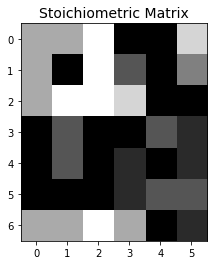


stoic_mtrx=
 [[-4.  4.  6.  0.  0. -5.]
 [-4.  0.  6.  2.  0. -3.]
 [-4. -6.  6.  5.  0.  0.]
 [ 0. -2.  0.  0.  2. -1.]
 [ 0. -2.  0.  1.  0.  1.]
 [ 0.  0.  0. -1.  2. -2.]
 [-4. -4.  6.  4.  0. -1.]]


In [9]:
'''Info on the data'''

print('species=',species)
from chen_3170.help import print_reactions
print('')
print_reactions(reactions) 
print('')
print('K_x eq = ',keq_cte)
print('')
from chen_3170.help import plot_matrix
plot_matrix(stoic_mtrx, title='Stoichiometric Matrix')
print('')
import numpy as np
np.set_printoptions(precision=3,threshold=100,edgeitems=5)
print('stoic_mtrx=\n',stoic_mtrx)

The following reference molar fraction $\xvec^{(0)}$ is given:

  Reference Molar Fraction    | Parameter    | Value |
------------------------------|--------------|-------|
 NO  | $x_{NO}$     | 0.1   |
 N2  | $x_{N2}$     | 0.1   |
 NO2 | $x_{NO2}$    | 0.0   |
 O2  | $x_{O2}$     | 0.3   |
 H2O | $x_{H2O}$    | 0.0   |
 NH3 | $x_{NH3}$    | 0.5   |

In [10]:
'''Set reference molar fraction'''

import numpy as np
x_dict_0 = {'NO':0.1,'N2':0.1,'NO2':0.0,'O2':0.3,'H2O':0.0,'NH3':0.5}

## Analyze Reaction Mechanism<a id="analyze"></a>

In [11]:
'''Check the rank of the stoichiometric matrix'''

try:    
    from chen_3170.toolkit import matrix_rank    
except ModuleNotFoundError:
    assert False, 'You need to provide your own matrix_rank function here. Bailing out.'

rank = matrix_rank( stoic_mtrx )
print('stoic_mtrx m x n =',stoic_mtrx.shape)
print('stoic_mtrx rank =',rank)

stoic_mtrx m x n = (7, 6)
stoic_mtrx rank = 3


In [12]:
'''Build the full-rank sub-mechanism reactions list'''

try:    
    from chen_3170.toolkit import sub_mechanisms    
except ModuleNotFoundError:
    assert False, 'You need to provide your own sub_mechanisms function here. Bailing out.'

sub_mechanisms = sub_mechanisms( species, reactions, stoic_mtrx )

# reactions =  7
# species   =  6
rank of S =  3
# of all possible sub_mechanisms = 35
# of full-rank sub_mechanisms = 24


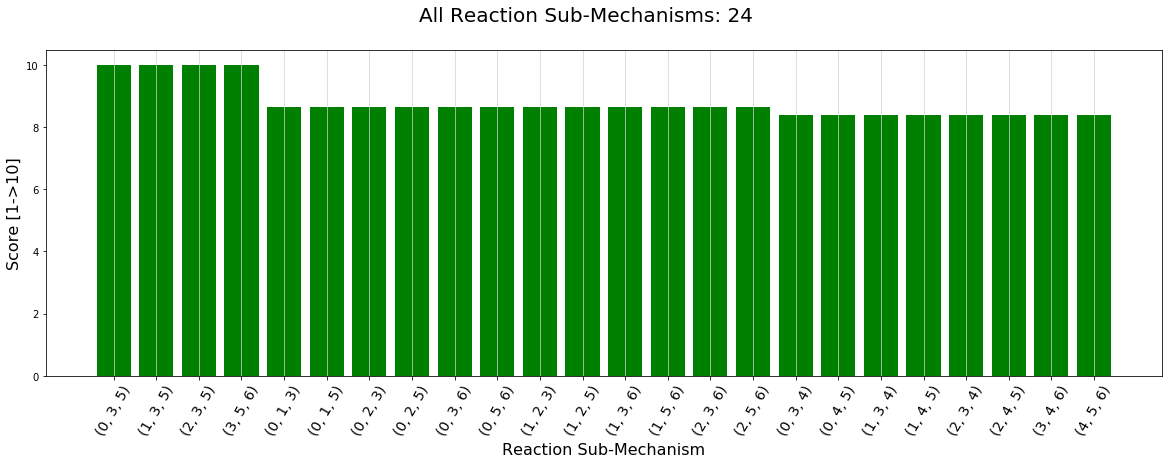

r0 :  4 NH3 + 5 O2        <=> 4 NO  + 6 H2O
r1 :  4 NH3 + 3 O2        <=> 2 N2  + 6 H2O
r2 :  4 NH3 + 6 NO        <=> 5 N2  + 6 H2O
r3 :  2 NO  + 1 O2        <=> 2 NO2
r4 :  2 NO                <=> 1 N2  + 1 O2
r5 :  1 N2  + 2 O2        <=> 2 NO2
r6 :  4 NH3 + 4 NO + 1 O2 <=> 4 N2  + 6 H2O
n_reactions = 7


In [13]:
'''Plot full-rank sub-mechanism reactions list'''

try:    
    from chen_3170.toolkit import plot_reaction_sub_mechanisms    
except ModuleNotFoundError:
    assert False, 'You need to provide your own plot_reaction_mechanisms function here. Bailing out.'
    
plot_reaction_sub_mechanisms( sub_mechanisms )
print_reactions(reactions)

## Setup Problem 1<a id="set1"></a>

Setup the first sub-mechanism. 

In [14]:
'''Select the first sub-mechanim'''

sub_mechanism_1 = sub_mechanisms[0]

for i in sub_mechanism_1:
    print(i)

(0, 3, 5)
['4 NH3 + 5 O2        <=> 4 NO  + 6 H2O', '2 NO  + 1 O2        <=> 2 NO2', '1 N2  + 2 O2        <=> 2 NO2']
[[-4.  4.  6.  0.  0. -5.]
 [ 0. -2.  0.  0.  2. -1.]
 [ 0.  0.  0. -1.  2. -2.]]
10.0


In [15]:
'''Setup first sub-mechanism'''
    
stoic_mtrx    = sub_mechanism_1[2]
reactions     = sub_mechanism_1[1]
reaction_ids  = sub_mechanism_1[0]
keq_cte_vec   = np.array(keq_cte)[list(reaction_ids)]

print('species=',species)
print('')
print_reactions(reactions) 
print('')
print('K_x eq = ',keq_cte_vec)
print('')
import numpy as np
np.set_printoptions(precision=3,threshold=100,edgeitems=5)
print('stoic_mtrx=\n',stoic_mtrx)

species= ['NH3', 'NO', 'H2O', 'N2', 'NO2', 'O2']

r0 :  4 NH3 + 5 O2        <=> 4 NO  + 6 H2O
r1 :  2 NO  + 1 O2        <=> 2 NO2
r2 :  1 N2  + 2 O2        <=> 2 NO2
n_reactions = 3

K_x eq =  [250.    100.    117.851]

stoic_mtrx=
 [[-4.  4.  6.  0.  0. -5.]
 [ 0. -2.  0.  0.  2. -1.]
 [ 0.  0.  0. -1.  2. -2.]]


In [16]:
'''Setup first sub-mechanism'''

x_vec_0 = np.zeros(len(species),dtype=np.float64)
for i in range(len(species)):
    x_vec_0[i] = x_dict_0[species[i]]
    
assert abs(np.sum(x_vec_0) - 1.0) <= 1e-12
assert np.all(x_vec_0 >=0.0)

## Plot Equilibrium Vector Function 1<a id="eqfunc1"></a>

Plot equilibrium vector function for the first sub-mechanism. 

In [17]:
'''Function: plot equilibrium function'''

def plot_keq_function( ext_hat_vec_min, ext_hat_vec_max, num_pts,
                       x_vec_0, keq_cte_vec, stoic_mtrx,
                       ext_hat_vec_root=None  ):
    
    import matplotlib.pyplot as plt
    plt.figure(1, figsize=(25, 5))
    
    # number of functions to be plotted
    num_keq_functions = keq_cte_vec.size
    
    import numpy as np
    
    # allocate a matrix for all ext_hat_vec plot points (min to max)
    ext_hat_plot_pts = np.zeros((num_pts,num_keq_functions))
    
    # create all plot points for ext_hat_vec
    for i in range(num_keq_functions):
        ext_hat_plot_pts[:,i] = np.linspace(ext_hat_vec_min[i], ext_hat_vec_max[i], num_pts)
    
    # allocate a matrix for all keq_function_vec plot points
    keq_function_plot_values = np.zeros((num_pts,num_keq_functions))
    
    # create all plot points for keq_function
    for i in range(num_keq_functions):
    
        for k in range(num_pts):
            x_vec = molar_fractions( ext_hat_plot_pts[k,:], x_vec_0, stoic_mtrx ) 
            keq_function_plot_values[k,:] = keq_function( x_vec, keq_cte_vec, stoic_mtrx )
    
    # Plot keq_function_vec in subplots
    n_rows = 1
    n_columns = num_keq_functions 
    # create colors for each equilibrium function
    color_ids = np.linspace(0,1,num_keq_functions)
    for (iplot,color_id) in zip(range(num_keq_functions),color_ids):
        plt.subplot(n_rows,n_columns, iplot+1)
        #color = plt.cm.nipy_spectral(color_id)
        color = plt.cm.cool(color_id)
        plt.plot(ext_hat_plot_pts[:,iplot], keq_function_plot_values[:,iplot],
                 color=color,label='$K_{x,%i}=$%8.2e'%(reaction_ids[iplot],keq_cte_vec[iplot]))
    
        plt.xlabel(r'$\hat{\varepsilon}_{%i}$'%reaction_ids[iplot],fontsize=18)
        plt.ylabel(r'$K_{%i}(\hat{\varepsilon})$'%reaction_ids[iplot],fontsize=18)
        plt.title(reactions[iplot],fontsize=20)
        plt.legend(loc='best',fontsize=12)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
    
        (x_min,x_max) = plt.xlim()
        dx = abs(x_max-x_min)
        x_text = x_max+dx*1/100
    
        (y_min,y_max) = plt.ylim()
        dy = abs(y_max-y_min)
        y_text = y_max - dy*0.1
    
        for x,spc in zip(x_vec_0,species):
            plt.text(x_text, y_text, r'$x_{%s}^{(0)}=$%8.2e'%(spc,x),fontsize=16)
            y_text -= dy*0.15
    
        if ext_hat_vec_root is not None:
            
            e_root = ext_hat_vec_root[iplot]
            plt.plot(e_root, 0.0,'r*',label='root',markersize=14)
               
            (x_min,x_max) = plt.xlim()
            dx = abs(x_max-x_min)
            x_text = e_root + dx*0.01
    
            (y_min,y_max) = plt.ylim()
            dy = abs(y_max-y_min)
            y_text = 0.0 + dy*0.01
    
            plt.text(x_text, y_text, r'$\hat{\varepsilon}^*=$%8.2e'%e_root,fontsize=16)
       
        plt.grid(True)
        plt.show()
        print('')
    
    return

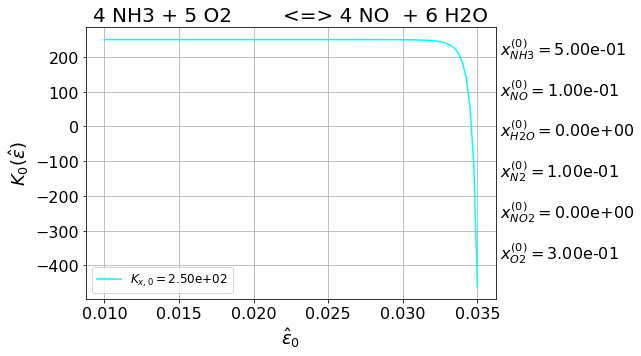

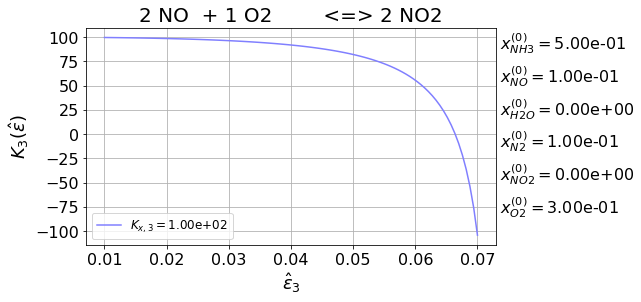

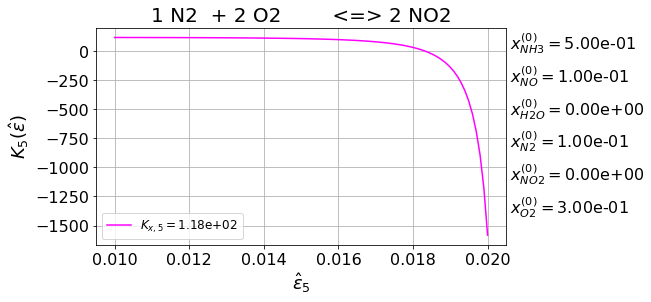

In [18]:
'''Plot equilibrium vector function'''

import numpy as np
num_keq_functions = keq_cte_vec.size
ext_hat_vec_min = .01*np.ones(num_keq_functions,dtype=np.float64)
ext_hat_vec_max = 0.035*np.ones(num_keq_functions,dtype=np.float64)
ext_hat_vec_max[0] = 0.035
ext_hat_vec_max[1] = 0.07
ext_hat_vec_max[2] = 0.020
n_pts = 100
plot_keq_function( ext_hat_vec_min, ext_hat_vec_max, n_pts, 
                   x_vec_0, keq_cte_vec, stoic_mtrx )

## Solve for Equilibrium 1<a id="solve1"></a>

Solve for equilibrium for the first sub-mechanism. 

In [19]:
'''Find root and equilibrium molar fractions'''

ext_hat_vec_0 = 1e-3 * np.ones(len(reactions),dtype=np.float64)
k_max = 50
tolerance = 1.0e-8

ext_hat_vec = newton_solve( x_vec_0, keq_cte_vec, stoic_mtrx,
                            ext_hat_vec_0, k_max, tolerance )

x_vec = molar_fractions( ext_hat_vec, x_vec_0, stoic_mtrx )

print('')
print('Equilibrium mole fractions:\n')
for (x,spc) in zip(x_vec,species):
    print('x_%s = %5.3e\n'%(spc,x))
    
assert np.all(x_vec >= 0.0)
assert abs(x_vec.sum() - 1.0) <= 1e-10



******************************************************
          Newton's Method Iterations                  
******************************************************
k |  K(e_k)  |  K'(e_k) | |del e_k| |    e_k   |convg|
------------------------------------------------------
 1 +2.939e+02 +1.584e+06 +7.332e-04  +2.414e-03  0.00
 2 +2.939e+02 +1.367e+06 +1.050e-03  +3.426e-03  0.95
 3 +2.939e+02 +1.183e+06 +1.523e-03  +4.910e-03  0.95
 4 +2.939e+02 +1.028e+06 +2.209e-03  +7.072e-03  0.94
 5 +2.939e+02 +8.969e+05 +3.171e-03  +1.019e-02  0.94
 6 +2.938e+02 +7.861e+05 +4.465e-03  +1.459e-02  0.94
 7 +2.936e+02 +6.932e+05 +6.096e-03  +2.062e-02  0.94
 8 +2.930e+02 +6.166e+05 +7.968e-03  +2.851e-02  0.95
 9 +2.918e+02 +5.551e+05 +9.810e-03  +3.824e-02  0.96
10 +2.889e+02 +5.084e+05 +1.115e-02  +4.926e-02  0.97
11 +2.825e+02 +4.766e+05 +1.138e-02  +6.039e-02  1.00
12 +2.710e+02 +4.594e+05 +9.983e-03  +6.978e-02  1.03
13 +2.577e+02 +4.524e+05 +6.360e-03  +7.533e-02  1.10
14 +2.507e+02 +4.414e

## Plot Equilibrium Point 1<a id="eqpt1"></a> 

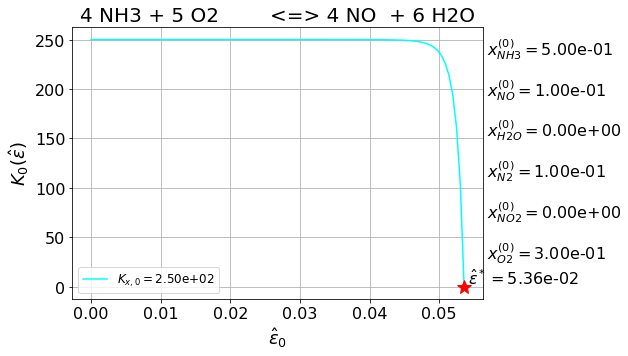

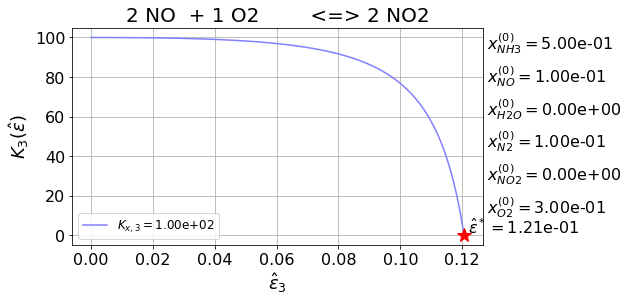

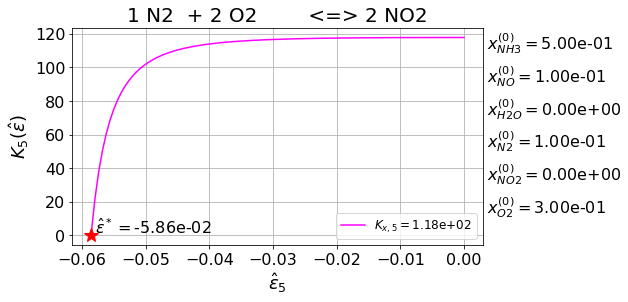

In [20]:
'''Plot equilibrium vector function'''

import numpy as np
n_keq_functions = keq_cte_vec.size
ext_hat_vec_min = np.zeros(n_keq_functions,dtype=np.float64)
ext_hat_vec_max = ext_hat_vec
n_pts = 100
plot_keq_function( ext_hat_vec_min, ext_hat_vec_max, n_pts, 
                   x_vec_0, keq_cte_vec, stoic_mtrx, ext_hat_vec )

## Setup Problem 2<a id="set2"></a>

Setup the last sub-mechanism. 

In [21]:
'''Select the first sub-mechanim'''

sub_mechanism_2 = sub_mechanisms[-1]

for i in sub_mechanism_2:
    print(i)

(4, 5, 6)
['2 NO                <=> 1 N2  + 1 O2', '1 N2  + 2 O2        <=> 2 NO2', '4 NH3 + 4 NO + 1 O2 <=> 4 N2  + 6 H2O']
[[ 0. -2.  0.  1.  0.  1.]
 [ 0.  0.  0. -1.  2. -2.]
 [-4. -4.  6.  4.  0. -1.]]
8.378378378378379


In [22]:
'''Setup first sub-mechanism'''
    
stoic_mtrx    = sub_mechanism_2[2]
reactions     = sub_mechanism_2[1]
reaction_ids  = sub_mechanism_2[0]
keq_cte_vec   = np.array(keq_cte)[list(reaction_ids)]

print('species=',species)
print('')
print_reactions(reactions) 
print('')
print('K_x eq = ',keq_cte_vec)
print('')
import numpy as np
np.set_printoptions(precision=3,threshold=100,edgeitems=5)
print('stoic_mtrx=\n',stoic_mtrx)

species= ['NH3', 'NO', 'H2O', 'N2', 'NO2', 'O2']

r0 :  2 NO                <=> 1 N2  + 1 O2
r1 :  1 N2  + 2 O2        <=> 2 NO2
r2 :  4 NH3 + 4 NO + 1 O2 <=> 4 N2  + 6 H2O
n_reactions = 3

K_x eq =  [  0.849 117.851 129.6  ]

stoic_mtrx=
 [[ 0. -2.  0.  1.  0.  1.]
 [ 0.  0.  0. -1.  2. -2.]
 [-4. -4.  6.  4.  0. -1.]]


## Solve for Equilibrium 2<a id="solve2"></a>

Solve for equilibrium for the last sub-mechanism. 

In [23]:
'''Find root and equilibrium molar fractions'''

ext_hat_vec_0 = 1e-3 * np.ones(len(reactions),dtype=np.float64)
k_max = 50
tolerance = 1.0e-8

ext_hat_vec = newton_solve( x_vec_0, keq_cte_vec, stoic_mtrx,
                            ext_hat_vec_0, k_max, tolerance )

x_vec = molar_fractions( ext_hat_vec, x_vec_0, stoic_mtrx )

print('')
print('Equilibrium mole fractions:\n')
for (x,spc) in zip(x_vec,species):
    print('x_%s = %5.3e\n'%(spc,x))
    
assert np.all(x_vec >= 0.0)
assert abs(x_vec.sum() - 1.0) <= 1e-10



******************************************************
          Newton's Method Iterations                  
******************************************************
k |  K(e_k)  |  K'(e_k) | |del e_k| |    e_k   |convg|
------------------------------------------------------
 1 +1.752e+02 +8.580e+05 +5.920e-02  +5.824e-02  0.00
 2 +1.752e+02 +4.608e+05 +1.674e-02  +4.155e-02  1.45
 3 +1.752e+02 +4.592e+05 +9.312e-03  +3.240e-02  1.14
 4 +1.752e+02 +4.393e+05 +2.511e-03  +3.056e-02  1.28
 5 +1.752e+02 +3.915e+05 +2.097e-03  +3.073e-02  1.03
 6 +1.751e+02 +3.437e+05 +3.050e-03  +3.106e-02  0.94
 7 +1.751e+02 +3.035e+05 +4.409e-03  +3.178e-02  0.94
 8 +1.751e+02 +2.700e+05 +6.243e-03  +3.348e-02  0.94
 9 +1.749e+02 +2.425e+05 +8.566e-03  +3.717e-02  0.94
10 +1.745e+02 +2.203e+05 +1.124e-02  +4.391e-02  0.94
11 +1.736e+02 +2.033e+05 +1.384e-02  +5.417e-02  0.95
12 +1.713e+02 +1.915e+05 +1.562e-02  +6.726e-02  0.97
13 +1.658e+02 +1.849e+05 +1.547e-02  +8.115e-02  1.00
14 +1.540e+02 +1.829e

## Plot Equilibrium Point 2<a id="eqpt1"></a> 

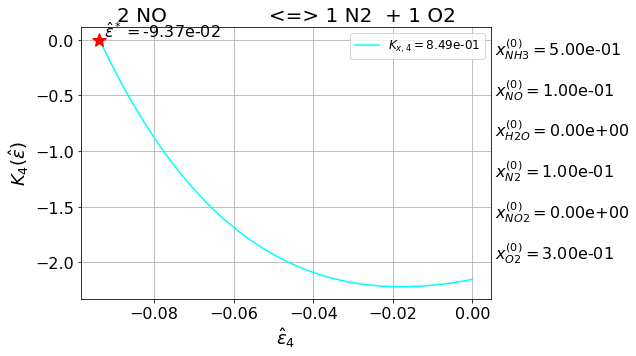

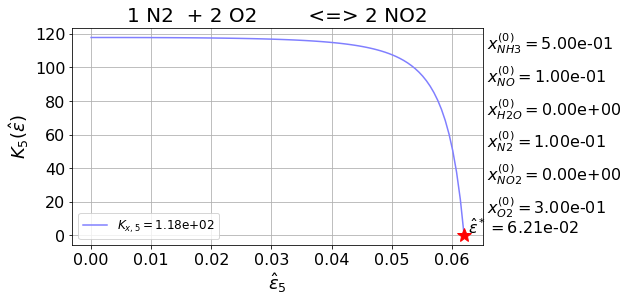

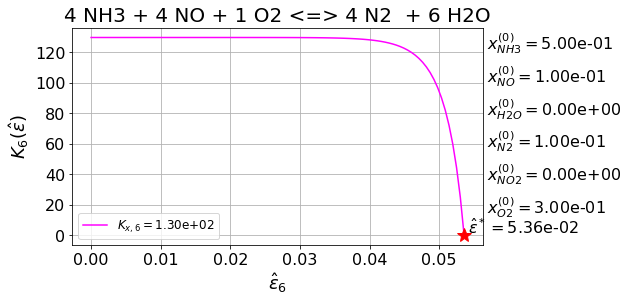

In [24]:
'''Plot equilibrium vector function'''

import numpy as np
n_keq_functions = keq_cte_vec.size
ext_hat_vec_min = np.zeros(n_keq_functions,dtype=np.float64)
ext_hat_vec_max = ext_hat_vec
n_pts = 100
plot_keq_function( ext_hat_vec_min, ext_hat_vec_max, n_pts, 
                   x_vec_0, keq_cte_vec, stoic_mtrx, ext_hat_vec )